100%|██████████| 9.91M/9.91M [00:00<00:00, 133MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 39.4MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 85.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.78MB/s]


Epoch [1/10] Loss: 45.1720
Epoch [2/10] Loss: 34.9497
Epoch [3/10] Loss: 33.0392
Epoch [4/10] Loss: 32.1979
Epoch [5/10] Loss: 31.6449
Epoch [6/10] Loss: 31.3058
Epoch [7/10] Loss: 31.0876
Epoch [8/10] Loss: 30.8796
Epoch [9/10] Loss: 30.7358
Epoch [10/10] Loss: 30.5795


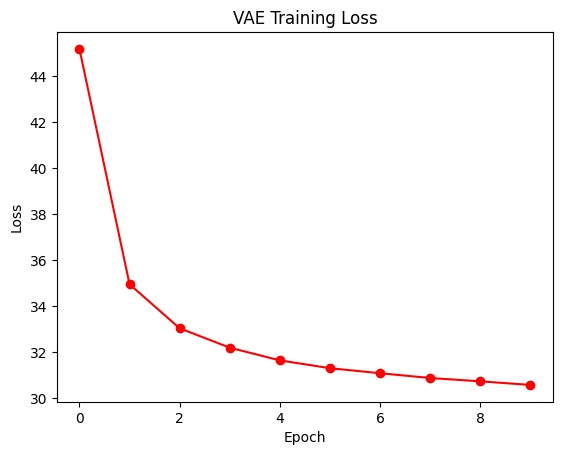

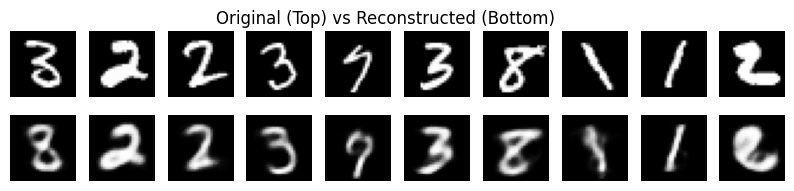

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, 20)
        self.fc_logvar = nn.Linear(400, 20)
        self.fc2 = nn.Linear(20, 400)
        self.fc3 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h3))

    def forward(self, x):
        x = x.view(-1, 28*28)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10
train_loss = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for img, _ in train_loader:
        recon, mu, logvar = model(img)
        loss = vae_loss(recon, img, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader.dataset)
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

plt.plot(train_loss, 'r-o')
plt.title("VAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

sample = next(iter(train_loader))[0][:10]
with torch.no_grad():
    reconstructed, _, _ = model(sample)

plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(sample[i].squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(2, 10, i+11)
    plt.imshow(reconstructed[i].view(28,28).detach().numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle("Original (Top) vs Reconstructed (Bottom)")
plt.show()
